# 村田安雄『動的経済システムの最適制御』第2章のシミュレーション

(Version: 0.0.1)

「第2章 投資の加速度原理の経済での安定化政策」について本にシミュレーション結果があるが、それを「追試」してみる。

ここでの streamplot などの知識は、南裕樹『Python による制御工学入門』から得た。

In [1]:
%matplotlib inline

In [2]:
from time import gmtime, strftime
print("Time-stamp: <%s>" % strftime("%Y-%m-%dT%H:%M:%SZ", gmtime()))

Time-stamp: <2022-05-08T18:51:35Z>


In [3]:
import matplotlib.pyplot as plt
import scipy.optimize
import numpy as np

どれぐらいの範囲の図にすればいいのか本からはわからない。とりあえず、-2.0 から 2.0 を 100 マスで区切ったものにする。

In [4]:
width = 2.0

Y, G = np.mgrid[-width:width:100j, -width:width:100j]

この部分、なぜか次のようにすると、streamplot が ValueError: setting an array element with a sequence. …というエラーを吐く。

In [5]:
# G, Y = np.mgrid[-width:width:100j, -width:width:100j]

各種パラメータは本の例のようにとった。

In [6]:
s = 0.3
nu = 4
rho = 0.1
phi = 2

w = rho / (1 - nu * rho)
theta = np.sqrt(w ** 2 + phi ** -1)

次の A は式 (22) そのまま。

In [7]:
A = np.array([[- s * w, w], [w / phi, s * w]])
ev, evec = np.linalg.eig(A)

print(ev)

[-0.1280191  0.1280191]


In [8]:
dY = A[0, 0] * Y + A[0, 1] * G
dG = A[1, 0] * Y + A[1, 1] * G

In [9]:
t = np.arange(-width, width, width/200)

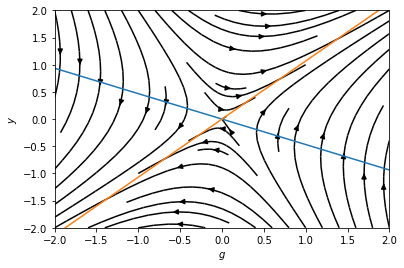

In [10]:
fig, ax = plt.subplots()

ax.streamplot(G, Y, dG, dY, density=0.7, color='k')

if ev.imag[0] == 0 and ev.imag[1] == 0:
    ax.plot(t, (evec[1,0]/evec[0,0]) * t, ls='-')
    ax.plot(t, (evec[1,1]/evec[0,1]) * t, ls='-')

ax.set_xlim([-width, width])
ax.set_ylim([-width, width])
ax.set_xlabel('$g$')
ax.set_ylabel('$y$')
None

さてここからが今回私がやりたかったことである。「最適化」を解析的に導出するのではなく、力技で scipy.optimize.minimize を使って求めたらどうなるか？…というのを試してみたかった。それをやってみる。

In [11]:
dt = 0.1

def calc_ys (y0, gs) :
    ys = [y0]
    g0 = gs[0]
    gs = gs[1:]
    y = y0
    g = g0
    for i, ng in enumerate(gs):
        dy = w * g - s * w * y # これは式 (12) そのものである。
        y = y + dy * dt
        g = ng
        ys.append(y)
    # assert len(ys) == len(gs) + 1
    return ys

def calc_score (gs, y0):
    ys = np.array(calc_ys(y0, gs))
    gs = np.array(gs)
    return np.sum(ys ** 2 + phi * gs ** 2)

フィリップスの最適安定化モデルでは、式 (13) の $J = \frac{1}{2}\int^T_0 (y^2 + \phi g ^2) dt$ を目的関数にしているが、ここでは np.sum(ys ** 2 + phi * gs ** 2) を使っている。

初期値は仮に y0 = -1 にしている。

In [12]:
y0 = -1

In [13]:
res = scipy.optimize.minimize(calc_score, [0] * 100, args=(y0,), method='Nelder-Mead')

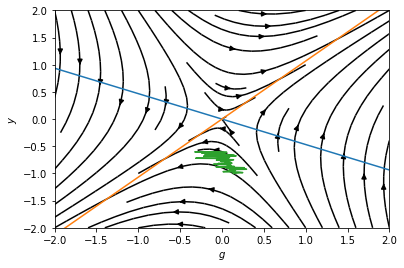

In [14]:
fig, ax = plt.subplots()

ax.streamplot(G, Y, dG, dY, density=0.7, color='k')

if ev.imag[0] == 0 and ev.imag[1] == 0:
    ax.plot(t, (evec[1,0]/evec[0,0]) * t, ls='-')
    ax.plot(t, (evec[1,1]/evec[0,1]) * t, ls='-')

ax.set_xlim([-width, width])
ax.set_ylim([-width, width])
ax.set_xlabel('$g$')
ax.set_ylabel('$y$')
# ここまでは上と同じ。
ax.plot(res.x, calc_ys(y0, res.x))
plt.show()

…ということで、上の緑のギザギザが「力技」なわけだが、あまりうまくいっていない。dt を小さくすればギザギザはとても小さくなりより streamplot の線に沿った形にはなるようだが、いかんせん小さすぎてちゃんとした値になっているかよくわからない。

ただ、この実験で、gs が百のパラメータからなるとても長いベクトルにしたわけだが、それがわりと短い時間で結果が出ている。それは今後にむけて心強い結果だといえる。